In [2]:
##############      Configuración      ##############
import sys
sys.path.append('..')  # Add the parent directory to the sys.path
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict
from dotenv import dotenv_values

pd.set_option("display.max_columns", None)
env = dotenv_values("/mnt/d/Maestría/Tesis/Repo/scripts/globals.env")

path_proyecto = env["PATH_PROYECTO"]
path_datain = env["PATH_DATAIN"]
path_dataout = env["PATH_DATAOUT"]
path_out_imgs = r"/mnt/e/Tesis Maestría/imagenes"
path_scripts = env["PATH_SCRIPTS"]
path_satelites = env["PATH_SATELITES"]
path_logs = env["PATH_LOGS"]
path_outputs = env["PATH_OUTPUTS"]

In [3]:
import earthpy.plot as ep
import build_dataset as bd
import utils
import geopandas as gpd
import shapely
import skimage
import folium
import pandas as pd
import seaborn as sns

raster_size = 58.435144 - 58.435139 # In epsg 4326 degrees

In [ ]:
datasets, extents = bd.load_satellite_datasets()
icpag = bd.load_icpag_dataset()
icpag = bd.assign_datasets_to_gdf(icpag, extents)

# Imagenes de Ejemplo

In [ ]:
import random
import skimage
import cv2
import os
img_folders = os.listdir(path_out_imgs)
img_folders = [folder for folder in img_folders if "train" in folder]

fig, axs = plt.subplots(4,7, figsize=(5*7, 5*4))
for row, folder in enumerate(img_folders):

    imgs = os.listdir(f"{path_out_imgs}/{folder}")
    show_imgs = random.sample(imgs, 7)

    for col, im_path in enumerate(show_imgs):

        im = np.load(f"{path_out_imgs}/{folder}/{im_path}")
        im = np.moveaxis(im, 0, 2)
        im = im[:,:,:3]
        # Equalize hist
        im = skimage.exposure.equalize_hist(im)
        im = cv2.resize(im, (128, 128))

        axs[row][col].imshow(im[:,:,:3])
        axs[row][col].set_axis_off()
        axs[row][col].set_title(f"{folder}_{row}")
        
# Remove axis lables
plt.axis("tight")

# Create training/validaton_by_epoch

In [3]:
path_repo = r"/mnt/d/Maestría/Tesis/Repo"
# path_repo = r"D:/Maestría/Tesis/Repo"
path_outputs = f"{path_repo}/outputs"
path_dataout = f"{path_repo}/data/data_out"


In [4]:
models =[
    "mobnet_v3_size128_tiles1_sample5",
    # "mobnet_v3_size256_tiles1_sample1",
    # "mobnet_v3_size512_tiles1_sample1",
    # "mobnet_v3_size128_tiles2_sample20",
]

old_models = { 
        'mobnet_v3_size128_tiles1_sample1':
            [
                'mobnet_v3_20230908-203439',
                'mobnet_v3_20230909-020833',
                'mobnet_v3_20230909-121048',
                'mobnet_v3_20230909-153231',
                'mobnet_v3_20230909-202517',
                'mobnet_v3_20230909-213040',
                'mobnet_v3_20230910-130103',
                'mobnet_v3_20230911-092415',
                'mobnet_v3_20230911-231611',
                'mobnet_v3_20230912-012855',
            ],
        'mobnet_v3_size256_tiles1_sample1':
            [       
                'mobnet_v3_20230914-215006',
                'mobnet_v3_20230913-200010',
            ],      
        'mobnet_v3_size512_tiles1_sample1':
            [
                'mobnet_v3_20230915-122541',
                'mobnet_v3_20230916-124818',
            ],
        'mobnet_v3_size128_tiles2_sample20':
            [
                'mobnet_v3_20230918-192554',
                'mobnet_v3_20230918-231134',
                'mobnet_v3_20230919-104912',
                'mobnet_v3_20230919-234505',
                'mobnet_v3_20230920-131123',
                'mobnet_v3_20230920-180458',
                'mobnet_v3_20230920-194725',
            ]
    }

In [ ]:
import tensorflow as tf
import tensorboard as tb
import numpy as np

# First, upload experiment to Tensorboard:
# 
# Extract data from TB
experiment_id = "CwPHXf5GQ9qdvTQcZoNyow"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()

for kind in ["train", "validation"]:
    # Keep only train values
    base = df[df.run.str.contains(f'{kind}') & (df.tag == 'epoch_loss')]
    base['run'] = base.run.str.replace(f"/{kind}", "")

    # Filter model
    models_by_date = {
        'mobnet_v3_size128_tiles1_sample5':[""]
    }

    base['model'] = np.nan
    for model, names in models_by_date.items():
        for name in names:
            base.loc[base.run.str.contains(name), 'model'] = model
            
    # Reshape data
    plot_data = base[~base.model.isna()]\
        .drop_duplicates(subset=['model','step'], keep='first')\
        .pivot(index='step', columns='model', values='value')
        
    # Export data
    plot_data.to_csv(f"{path_repo}/data/data_out/{kind}_by_epoch.csv")

# True Mean Squared error

In [10]:
from tqdm import tqdm
import pandas as pd

path_repo = r"/mnt/d/Maestría/Tesis/Repo"
# path_repo = r"D:/Maestría/Tesis/Repo"
path_outputs = f"{path_repo}/outputs"
path_dataout = f"{path_repo}/data/data_out"

def get_model_results(modelname):
    
    folder = f"{path_repo}/data/data_out/models_by_epoch/{modelname}"
 
    # Get train dataset
    train_data = pd.read_csv(rf"{path_dataout}/train_by_epoch.csv")
    mse_train_df = train_data[[modelname]]
    # TODO: Calcular el R2
    mse_train_df = mse_train_df.reset_index().rename(columns={'index':'epoch', modelname:'mse_train'})

    # Get validation (test by each image) dataset
    test2_data = pd.read_csv(rf"{path_dataout}/validation_by_epoch.csv")
    mse_test2_df = test2_data[[modelname]]
    # TODO: Calcular el R2
    mse_test2_df = mse_test2_df.reset_index().rename(columns={'index':'epoch', modelname:'mse_test_imgs'})

    # Get test dataset
    mse_test_df = pd.DataFrame()
    for epoch in tqdm(range(0, 200)):

        df = pd.read_csv(f"{folder}/{modelname}_{epoch}.csv")
        mse = df.groupby("link").sq_error.mean().mean()

        mse_test_df.at[epoch, 'mse_test_rc'] = mse
        mse_test_df.at[epoch, 'epoch'] = epoch    
    
    # Merge both df
    mse_df = mse_train_df.merge(mse_test_df, on='epoch')
    mse_df = mse_df.merge(mse_test2_df, on='epoch')

    return mse_df

In [ ]:
def plot_mse_over_epochs(mse_df, modelname, metric="mse", save=False):
    import plotly.express as px
    from plotly import graph_objects as go

    plot_df = mse_df.melt(id_vars='epoch', value_vars=['mse_test_imgs', 'mse_test_rc','mse_train'])

    # Plot
    fig = px.line(plot_df, x="epoch", y="value", color="variable", title='True Mean Squared Error over epochs')
    fig.update_yaxes(range=[0, 1])

    fig.update_layout(
        autosize=False,
        width=1280,
        height=720,)

    if save:
        fig.write_image(f"{path_outputs}/mse_best_prediction_{modelname}.png")

    return fig
    
def plot_predictions_vs_real(mse_df, modelname, quantiles=False, last_training=False, save=False):
    import plotly.express as px
    from plotly import graph_objects as go

    folder = f"{path_repo}/data/data_out/models_by_epoch/{modelname}"
    
    # Select best epoch... ¿Is this correct?       
    best_case_epoch = mse_df.loc[mse_df["mse_test_rc"]==mse_df["mse_test_rc"].min()].index.values[0]

    if last_training:
        best_case_epoch = 199
        
    # Open dataset
    best_case = pd.read_csv(
        rf"{folder}/{modelname}_{best_case_epoch}.csv"
        )
    best_case = best_case.groupby("link")[['real_value', 'mean_prediction']].mean().reset_index()
    if quantiles:
        best_case['real_value'] = pd.qcut(best_case['real_value'], 100, labels=False)
        best_case['mean_prediction'] = pd.qcut(best_case['mean_prediction'], 100, labels=False)
        axis_range = [0, 100]
        title = f"{modelname} - cuantiles"
    else:
        axis_range = [-2, 2]
        title = f"{modelname} - niveles"
        
    import seaborn as sns
    fig = px.scatter(best_case, x="real_value", y="mean_prediction", hover_data=["link"],
                     title=title)
    fig.update_yaxes(range=axis_range)
    fig.update_xaxes(range=axis_range)
    fig.update_layout(
        autosize=False,
        width=800,
        height=800,)

    # Add 45° line
    line_fig = go.Figure(data=go.Scatter(x=best_case['real_value'], y=best_case['real_value'], mode='lines', name='45°'))
    fig.add_trace(line_fig.data[0])

    if save:
        if quantiles:
            fig.write_image(f"{path_outputs}/prediction_vs_real_best_prediction_{modelname}_q.png")
        else:
            fig.write_image(f"{path_outputs}/prediction_vs_real_best_prediction_{modelname}.png")
    return fig

In [12]:
def plot_all_over_epochs(modelnames, metric="mse", save=True):
    import plotly.express as px
    from plotly import graph_objects as go

    plot_data = []
    for modelname in modelnames:
        # Get data
        mse_df = get_model_results(modelname)

        # Prepare dataset for plot
        var_x = icpag.groupby("link")['var'].first().var()
        mse_df['r2'] = 1 - mse_df.mse / var_x
        mse_df['smoothed_mse'] = mse_df.rolling(20).mse.mean()
        mse_df['smoothed_r2'] = mse_df.rolling(20).r2.mean()

        melt_df = mse_df.melt(id_vars='epoch')
        plot_df = melt_df[melt_df.variable.isin([metric, f'smoothed_{metric}'])] 
        plot_df['name'] = f"{modelname}" + plot_df["variable"]
        plot_data += [plot_df.copy()]
        
    plot_data = pd.concat(plot_data)
    # Plot
    fig = px.line(plot_data, x="epoch", y="value", color="name")

    if metric=="mse":
        optimal_value_y = mse_df["mse"].min()
        name = "min_mse"
    elif metric=="r2":
        optimal_value_y = mse_df["r2"].max()
        name = "max_r2"
    else:
        raise ValueError("metric has to be either 'mse' or 'r2'")
    
    fig.update_layout(
        autosize=False,
        width=1200,
        height=800,)

    
    fig.update_yaxes(range=[0.1, 1.2])
        
    if save:
        main_fig.write_image(f"{path_outputs}/{metric}_best_prediction_{modelname}.png")

    # fig.write_image(f"{path_outputs}/mse_best_prediction_mobnet_v3_size{size}_tiles{tiles}_sample{sample}.png")
    return fig


In [13]:
models =[
    # "mobnet_v3_size128_tiles1_sample1",
    # "mobnet_v3_size256_tiles1_sample1",
    # "mobnet_v3_size512_tiles1_sample1",
    "mobnet_v3_size128_tiles1_sample5",
]

for modelname in models:
    mse_df = get_model_results(modelname)
    plot_mse_over_epochs(mse_df, modelname, metric="mse", save=True)
    plot_mse_over_epochs(mse_df, modelname, metric="r2", save=True)
    plot_predictions_vs_real(mse_df, modelname=modelname, save=True)
    plot_predictions_vs_real(mse_df, modelname=modelname, quantiles=True, save=True)


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:12<00:00, 15.72it/s]


In [9]:
modelname = rf"mobnet_v3_size128_tiles1_sample1"
mse_df = get_model_results(modelname)

KeyError: "None of [Index(['mobnet_v3_size128_tiles1_sample1'], dtype='object')] are in the [columns]"

In [ ]:
plot_predictions_vs_real(mse_df, modelname=modelname)

In [ ]:
plot_predictions_vs_real(mse_df, modelname=modelname, quantiles=True)

# Gridded predictions

In [ ]:
import os
import importlib
import build_dataset
import run_model
import tensorflow as tf
importlib.reload(build_dataset)
importlib.reload(run_model)

# Load data
datasets, extents = build_dataset.load_satellite_datasets()
icpag = build_dataset.load_icpag_dataset()
icpag = build_dataset.assign_datasets_to_gdf(icpag, extents)

# Model
modelpath = rf"{folder}/mobnet_v3_size{size}_tiles{tiles}_sample{sample}_{best_case_epoch}"
model = tf.keras.models.load_model(
           modelpath, compile=True
        )

# Run predictions
grid_preds_folder = f"{path_repo}/data/data_out/gridded_predictions/mobnet_v3_size{size}_tiles{tiles}_sample{sample}"
os.makedirs(grid_preds_folder, exist_ok=True)

for name, ds in datasets.items():
    df_preds = build_dataset.get_gridded_predictions_for_grid(
        model=model, ds=ds, extents=extents, icpag=icpag, tiles=1, size=size, resizing_size=128, bias=2, sample=1, to8bit=True
    )
    df_preds.to_parquet(f"{grid_preds_folder}/{name}.parquet")

In [ ]:
m = df_preds.explore(column="predictions", cmap="Spectral",
                tiles="https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}", attr="ESRI",
                vmax=df_preds.predictions.quantile(.95), vmin=df_preds.predictions.quantile(.05)
)
folium.LayerControl().add_to(m)
m

In [ ]:
import build_dataset

build_dataset.get_random_images_for_link(
    ds, icpag, link, 2, 512, 128, 2, 5, to8bit=True
)

2023-12-20 16:08:24.072953: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-20 16:08:26.401315: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/nico/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
2023-12-20 16:08:30.553622: I

Links without images: 4159 out of 10955


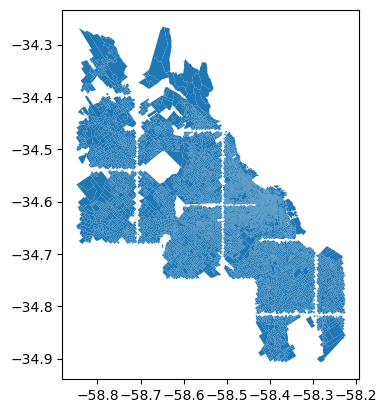

In [4]:
import os
import importlib
import build_dataset
import run_model
import tensorflow as tf
importlib.reload(build_dataset)
importlib.reload(run_model)

size = 256
tiles = 1
sample = 3
best_case_epoch = 2
folder="/mnt/d/Maestría/Tesis/Repo/data/data_out/models_by_epoch/"
path_repo="/mnt/d/Maestría/Tesis/Repo"
# # Load data
datasets, extents = build_dataset.load_satellite_datasets()
icpag = build_dataset.load_icpag_dataset()
icpag = build_dataset.assign_datasets_to_gdf(icpag, extents)

In [5]:
# Model
modelpath = rf"{folder}/mobnet_v3_size{size}_tiles{tiles}_sample{sample}_nostack/mobnet_v3_size{size}_tiles{tiles}_sample{sample}_nostack_{best_case_epoch}"
model = tf.keras.models.load_model(
           modelpath, compile=True
        )

# Run predictions
grid_preds_folder = f"{path_repo}/data/data_out/gridded_predictions/mobnet_v3_size{size}_tiles{tiles}_sample{sample}_nostack"
os.makedirs(grid_preds_folder, exist_ok=True)



2023-12-20 16:08:51.272960: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-20 16:08:51.274420: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-20 16:08:51.274964: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-20 16:08:54.088341: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-20 16:08:54.088952: I tensorflow/compile

In [23]:
import importlib
importlib.reload(build_dataset)

predictions = build_dataset.get_gridded_images_for_grid(
    model, datasets, icpag, size, 128, n_bands=4
)  

/mnt/d/Maestría/Tesis/Repo/scripts/notebooks/../build_dataset.py:628: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid = grid[grid.centroid.within(exterior)]
/home/nico/miniconda3/envs/tf/lib/python3.9/site-packages/geopandas/tools/clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


data ready


/mnt/d/Maestría/Tesis/Repo/scripts/notebooks/../build_dataset.py:656: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid["point"] = grid.centroid
3719it [09:32,  3.89it/s] 

16/16 [==============================] - 1s 28ms/step


5430it [11:50,  1.32it/s] 

16/16 [==============================] - 1s 29ms/step


6994it [14:01, 15.00it/s] 

16/16 [==============================] - 1s 36ms/step


8424it [16:06,  1.41it/s]

16/16 [==============================] - 1s 26ms/step


9724it [18:01,  6.09it/s] 

16/16 [==============================] - 1s 28ms/step


10970it [20:14,  1.41it/s]

16/16 [==============================] - 1s 37ms/step


12320it [22:23,  1.16it/s]

16/16 [==============================] - 1s 31ms/step


13624it [24:20,  1.09it/s]

16/16 [==============================] - 1s 28ms/step


14949it [26:38,  1.14it/s]

16/16 [==============================] - 1s 28ms/step


16290it [28:48,  1.35it/s] 

16/16 [==============================] - 1s 25ms/step


17542it [30:53,  1.06it/s] 

16/16 [==============================] - 1s 27ms/step


18846it [32:39,  4.88it/s]

16/16 [==============================] - 1s 27ms/step


20107it [34:25,  1.11it/s] 

16/16 [==============================] - 1s 26ms/step


21399it [36:14,  1.50it/s] 

16/16 [==============================] - 1s 29ms/step


22663it [38:12,  1.38it/s] 

16/16 [==============================] - 0s 24ms/step


23905it [40:15,  1.09it/s] 

16/16 [==============================] - 1s 34ms/step


25202it [42:10,  1.38it/s] 

16/16 [==============================] - 1s 33ms/step


26482it [43:59,  1.37it/s] 

16/16 [==============================] - 1s 25ms/step


27748it [46:40,  1.85it/s] 

16/16 [==============================] - 1s 25ms/step


29088it [48:27,  2.24it/s] 

16/16 [==============================] - 1s 29ms/step


30400it [50:12,  1.39it/s] 

16/16 [==============================] - 1s 27ms/step


31841it [52:06,  1.03it/s] 

16/16 [==============================] - 1s 26ms/step


33356it [53:55,  2.31it/s] 

16/16 [==============================] - 1s 27ms/step


34274it [54:26, 22.35it/s] 

error en imagen: 91284


34882it [55:41, 86.05it/s] 

16/16 [==============================] - 1s 29ms/step


36546it [58:04,  1.05it/s] 

16/16 [==============================] - 1s 29ms/step


38241it [1:00:14,  1.94it/s]

16/16 [==============================] - 1s 35ms/step


40217it [1:02:30,  1.18it/s] 

16/16 [==============================] - 1s 24ms/step


42323it [1:05:25,  7.28it/s] 

16/16 [==============================] - 0s 22ms/step


47239it [1:07:29,  3.44it/s] 

16/16 [==============================] - 1s 26ms/step


49574it [1:09:20,  1.25it/s] 

16/16 [==============================] - 0s 24ms/step


51522it [1:11:03, 127.34it/s]

16/16 [==============================] - 1s 27ms/step


53326it [1:12:49,  1.70it/s] 

16/16 [==============================] - 1s 24ms/step


55267it [1:14:30, 115.63it/s]

16/16 [==============================] - 1s 26ms/step


57096it [1:15:56,  1.97it/s] 

16/16 [==============================] - 1s 26ms/step


58870it [1:17:18,  3.99it/s] 

16/16 [==============================] - 1s 36ms/step


60584it [1:18:43,  3.48it/s] 

16/16 [==============================] - 0s 25ms/step


62278it [1:20:08, 25.38it/s] 

16/16 [==============================] - 1s 34ms/step


63917it [1:23:33,  1.27s/it] 

16/16 [==============================] - 1s 30ms/step


64720it [1:23:51, 68.71it/s] 

error en imagen: 139264


65007it [1:24:02, 129.23it/s]

error en imagen: 139509
error en imagen: 139510


65647it [1:24:59,  1.85it/s] 

16/16 [==============================] - 0s 25ms/step


67323it [1:26:29,  2.95it/s] 

16/16 [==============================] - 1s 48ms/step


68836it [1:27:56,  2.19it/s] 

16/16 [==============================] - 1s 27ms/step


70270it [1:29:24, 20.79it/s] 

16/16 [==============================] - 0s 24ms/step


71614it [1:30:50,  2.62it/s]

16/16 [==============================] - 0s 25ms/step


73085it [1:32:17,  1.61it/s] 

16/16 [==============================] - 1s 30ms/step


74597it [1:33:48,  2.17it/s] 

16/16 [==============================] - 1s 26ms/step


76222it [1:35:14,  2.01it/s] 

16/16 [==============================] - 1s 29ms/step


76688it [1:35:24, 52.22it/s] 

error en imagen: 157006


77890it [1:36:32,  2.27it/s] 

16/16 [==============================] - 0s 26ms/step


79601it [1:37:46,  3.22it/s] 

16/16 [==============================] - 1s 38ms/step


81223it [1:38:57, 128.19it/s]

16/16 [==============================] - 1s 35ms/step


82749it [1:40:28,  9.41it/s] 

16/16 [==============================] - 0s 25ms/step


84136it [1:41:44,  2.16it/s] 

16/16 [==============================] - 1s 29ms/step


85518it [1:42:56, 11.87it/s] 

16/16 [==============================] - 0s 26ms/step


86792it [1:44:12, 76.14it/s] 

16/16 [==============================] - 1s 25ms/step


88096it [1:45:22, 14.85it/s] 

16/16 [==============================] - 0s 26ms/step


89409it [1:46:40,  3.76it/s] 

16/16 [==============================] - 0s 26ms/step


90715it [1:47:52,  3.06it/s] 

16/16 [==============================] - 0s 25ms/step


92018it [1:49:06,  2.77it/s] 

16/16 [==============================] - 0s 24ms/step


93326it [1:50:17,  3.82it/s] 

16/16 [==============================] - 0s 24ms/step


94621it [1:51:41,  2.01it/s] 

16/16 [==============================] - 1s 32ms/step


95931it [1:53:02,  2.34it/s] 

16/16 [==============================] - 0s 22ms/step


97252it [1:54:19,  1.27it/s] 

16/16 [==============================] - 1s 27ms/step


98551it [1:55:33,  1.27it/s] 

16/16 [==============================] - 1s 36ms/step


99839it [1:56:45,  3.78it/s] 

16/16 [==============================] - 1s 33ms/step


101134it [1:57:52,  4.59it/s] 

16/16 [==============================] - 1s 31ms/step


102499it [1:59:21,  3.97it/s] 

16/16 [==============================] - 0s 23ms/step


103421it [1:59:58, 19.98it/s] 

error en imagen: 197821


103832it [2:00:59,  1.63it/s] 

16/16 [==============================] - 1s 36ms/step


105224it [2:03:14,  1.05it/s] 

16/16 [==============================] - 1s 26ms/step


106803it [2:06:59,  1.18s/it] 

16/16 [==============================] - 1s 27ms/step


108467it [2:10:26,  1.02it/s] 

16/16 [==============================] - 1s 37ms/step


110152it [2:15:02,  1.68s/it] 

16/16 [==============================] - 1s 26ms/step


112043it [2:20:02,  2.07it/s] 

16/16 [==============================] - 1s 30ms/step


114047it [2:24:07,  5.26it/s] 

16/16 [==============================] - 1s 33ms/step


116901it [2:24:57, 18.04it/s] 

error en imagen: 219391


117697it [2:29:34,  1.38s/it] 

16/16 [==============================] - 1s 39ms/step


118689it [2:29:57, 139.83it/s]

error en imagen: 222521


119544it [2:34:49,  1.27s/it] 

16/16 [==============================] - 1s 28ms/step


121300it [2:40:50,  1.18it/s] 

16/16 [==============================] - 1s 31ms/step


122888it [2:46:39,  1.97s/it] 

16/16 [==============================] - 1s 25ms/step


124553it [2:53:06,  1.61s/it] 

16/16 [==============================] - 1s 27ms/step


126168it [2:58:52,  1.42s/it] 

16/16 [==============================] - 1s 31ms/step


127743it [3:04:45,  1.71s/it] 

16/16 [==============================] - 1s 28ms/step


129418it [3:10:43,  6.01it/s] 

16/16 [==============================] - 1s 27ms/step


131008it [3:15:33,  4.08it/s] 

16/16 [==============================] - 1s 29ms/step


132743it [3:16:52,  2.60it/s] 

16/16 [==============================] - 1s 28ms/step


134479it [3:18:10,  2.49it/s] 

16/16 [==============================] - 1s 28ms/step


136235it [3:19:18,  4.13it/s] 

error en imagen: 258404


136267it [3:19:30,  1.93it/s]

16/16 [==============================] - 1s 27ms/step


136314it [3:19:32, 31.52it/s]

error en imagen: 258468


137896it [3:20:47, 26.07it/s] 

16/16 [==============================] - 1s 30ms/step


139213it [3:22:07,  2.09it/s] 

16/16 [==============================] - 1s 27ms/step


139477it [3:22:14, 40.03it/s] 

error en imagen: 265597


140444it [3:23:20,  2.66it/s]

16/16 [==============================] - 1s 29ms/step


141635it [3:24:37,  2.27it/s]

16/16 [==============================] - 0s 25ms/step


142782it [3:25:52,  1.88it/s]

16/16 [==============================] - 0s 25ms/step


143892it [3:27:02,  2.77it/s]

16/16 [==============================] - 1s 34ms/step


144978it [3:28:15,  3.15it/s]

16/16 [==============================] - 1s 28ms/step


146039it [3:29:33,  1.76it/s]

16/16 [==============================] - 1s 31ms/step


147113it [3:30:44,  3.05it/s]

16/16 [==============================] - 1s 29ms/step


148184it [3:33:07,  1.08it/s]

16/16 [==============================] - 1s 29ms/step


149255it [3:35:46,  1.38it/s]

16/16 [==============================] - 1s 27ms/step


150328it [3:36:55,  5.26it/s]

16/16 [==============================] - 1s 38ms/step


151403it [3:38:07,  5.85it/s]

16/16 [==============================] - 1s 45ms/step


152468it [3:39:15,  5.77it/s]

16/16 [==============================] - 1s 36ms/step


153556it [3:40:18,  8.43it/s]

16/16 [==============================] - 1s 59ms/step


154660it [3:41:22,  5.85it/s]

16/16 [==============================] - 1s 38ms/step


155848it [3:42:26,  6.31it/s]

16/16 [==============================] - 1s 33ms/step


157139it [3:43:30,  6.56it/s]

16/16 [==============================] - 1s 36ms/step


158545it [3:44:36,  5.77it/s]

16/16 [==============================] - 1s 40ms/step


160176it [3:45:47,  3.63it/s] 

16/16 [==============================] - 1s 42ms/step


161941it [3:46:57,  3.20it/s] 

16/16 [==============================] - 1s 37ms/step


163898it [3:48:08,  4.13it/s] 

16/16 [==============================] - 1s 42ms/step


165714it [3:49:29,  2.72it/s] 

16/16 [==============================] - 1s 33ms/step


168590it [3:51:08,  1.69it/s] 

16/16 [==============================] - 1s 33ms/step


169967it [3:53:20,  1.39it/s] 

16/16 [==============================] - 1s 32ms/step


171057it [3:54:30,  4.21it/s]

16/16 [==============================] - 1s 34ms/step


172120it [3:55:37,  3.09it/s]

16/16 [==============================] - 1s 31ms/step


173182it [3:56:48,  2.14it/s]

16/16 [==============================] - 1s 37ms/step


174260it [3:58:07,  1.61it/s]

16/16 [==============================] - 1s 33ms/step


175349it [3:59:16,  3.18it/s]

16/16 [==============================] - 1s 38ms/step


176539it [4:00:29,  2.88it/s]

16/16 [==============================] - 1s 32ms/step


176849it [4:00:33, 12.25it/s] 


In [20]:
predictions.set_crs(epsg=4326, allow_override=True).head(10000).explore()

In [17]:
predictions

id                                           geometry       link  \
0        30131  POLYGON ((-58.84969 -34.47612, -58.84969 -34.4...  066380904   
1        30132  POLYGON ((-58.84969 -34.47730, -58.84969 -34.4...  066380904   
2        30275  POLYGON ((-58.84969 -34.64604, -58.84969 -34.6...  065602201   
3        30766  POLYGON ((-58.84851 -34.45842, -58.84851 -34.4...  066380812   
4        30773  POLYGON ((-58.84851 -34.46668, -58.84851 -34.4...  066380813   
...        ...                                                ...        ...   
117755  372353  POLYGON ((-58.22901 -34.85608, -58.22901 -34.8...  062741010   
117756  372354  POLYGON ((-58.22901 -34.85726, -58.22901 -34.8...  062741011   
117757  372355  POLYGON ((-58.22901 -34.85844, -58.22901 -34.8...  062741011   
117758  372356  POLYGON ((-58.22901 -34.85962, -58.22901 -34.8...  062741011   
117759  372901  POLYGON ((-58.22783 -34.73572, -58.22783 -34.7...  066580407   

        prediction  link_actual_value  
0         1.665187          -1.153830  
1         1.665188          -1.153830  
2         1.665188          -1.130650  
3         1.665187           0.088655  
4         1.665187          -0.777118  
...            ...                ...  
117755    1.665188          -1.538630  
117756    1.665188          -1.222608  
117757    1.665188          -1.222608  
117758    1.665188          -1.222608  
117759    1.665188          -0.273416  

[117760 rows x 5 columns]

In [117]:
predictions.set_crs(epsg=4326, allow_override=True).explore(column="prediction")

In [ ]:
import run_model
from shapely.geometry import Polygon

# Inicializo arrays
batch_images = np.empty((0, resizing_size, resizing_size, 4))
batch_link_names = np.empty((0))
batch_predictions = np.empty((0))
batch_real_values = np.empty((0))
batch_bounds = np.empty((0))
all_link_names = np.empty((0))
all_predictions = np.empty((0))
all_real_values = np.empty((0))
all_bounds = np.empty((0))

tile_size = size // tiles
tiles_generated = 0

# Iterate over the center points of each image:
# - Start point is the center of the image (tile_size / 2, start_index)
# - End point is the maximum possible center point (link_dataset.y.size)
# - Step is the size of each image (tile_size)

# FIXME: para mejorar la eficiencia, convendría hacer un dissolve de icpag y verificar que
# point_geom este en ese polygono y no en todo el df
start_index = int(tile_size / 2)
for idy in range(start_index, ds.y.size, tile_size):
    # Iterate over columns
    for idx in range(start_index, ds.x.size, tile_size):
        # Get the center point of the image
        image_point = (float(ds.x[idx]), float(ds.y[idy]))
        point_geom = sg.Point(image_point)

        # Get data for selected point
        radio_censal = icpag.loc[icpag.contains(point_geom)]
        if radio_censal.empty:
            # El radio censal no existe, es el medio del mar...
            continue

        real_value = radio_censal["var"].values[0]
        link_name = radio_censal["link"].values[0]

        # Check if the centroid of the image is within the original polygon:
        #   - if it is, then generate the n images

        image, point, bound, tbound = utils.random_image_from_census_tract(
            ds,
            icpag,
            link_name,
            start_point=image_point,
            tiles=tiles,
            size=size,
            bias=bias,
            to8bit=to8bit,
        )

        if image is not None:
            image = utils.process_image(image, resizing_size)
            geom_bound = Polygon(
                bound[0]
            )  # Create polygon of the shape of the image

            batch_images = np.concatenate([batch_images, np.array([image])], axis=0)
            batch_link_names = np.concatenate(
                [batch_link_names, np.array([link_name])], axis=0
            )
            batch_real_values = np.concatenate(
                [batch_real_values, np.array([real_value])], axis=0
            )
            batch_bounds = np.concatenate(
                [batch_bounds, np.array([geom_bound])], axis=0
            )

            # predict with the model over the batch
            if batch_images.shape[0] == 128:
                # predictions
                batch_predictions = run_model.get_batch_predictions(
                    model, batch_images
                )

                # Store data
                all_predictions = np.concatenate(
                    [all_predictions, batch_predictions], axis=0
                )
                all_link_names = np.concatenate(
                    [all_link_names, batch_link_names], axis=0
                )
                all_real_values = np.concatenate(
                    [all_real_values, batch_real_values], axis=0
                )
                all_bounds = np.concatenate([all_bounds, batch_bounds], axis=0)

                # Restore batches to empty
                batch_images = np.empty((0, resizing_size, resizing_size, 4))
                batch_predictions = np.empty((0))
                batch_link_names = np.empty((0))
                batch_predictions = np.empty((0))
                batch_real_values = np.empty((0))
                batch_bounds = np.empty((0))

# Creo dataframe para exportar:
d = {
    "link": all_link_names,
    "predictions": all_predictions,
    "real_value": all_real_values,
}

df_preds = gpd.GeoDataFrame(d, geometry=all_bounds, crs="epsg:4326")
